In [83]:
import tensortools as tt
import numpy as np
import matplotlib.pyplot as plt

import musclebeachtools
from braingeneers import neuron
import glob
import sys

from scipy.ndimage import gaussian_filter1d

In [84]:
sys.modules['musclebeachtools_hlab'] = sys.modules['musclebeachtools']
sys.modules['musclebeachtools_hlab.musclebeachtools'] = sys.modules['musclebeachtools']

# Later download/deal with pathing to dhe results directory

In [4]:
chs = glob.glob("/Users/seymour/research/braingeneers/ephys/root/data/2020-12-01-e-MGK-primary-axion-stim-500mV-20sec/results/*")

In [5]:
def get_well(chs):
    '''chs -- file list in the results folder of the axion data output'''
    # Sort
    chs = sorted(chs)

    # Remove rasters 
    chs = [ch for ch in chs if 'rasters' not in ch]

    well_dict = {}
    seen_ch = []

    for ch in chs:

        well_grp = ch.split('/')[-1]
#         print(well_grp)
        well, grp = well_grp.split('chgroup')
#         print(well,grp)

        #Maps group to full name
        temp = {well+grp:ch}

        if well not in seen_ch:
            seen_ch.append(well)
            well_dict[well] = {}

        well_dict[well][int(grp)] = ch


    return well_dict

In [6]:
well_dict = get_well(chs)
well_dict['A1'][1]

'/Users/seymour/research/braingeneers/ephys/root/data/2020-12-01-e-MGK-primary-axion-stim-500mV-20sec/results/A1chgroup1'

## Load the neuron spike times

In [17]:
nf = glob.glob(well_dict['A1'][1] + '/spikeintf/outputs/neurons*')
data = np.load(nf[0],allow_pickle=True)

print(data[0].fs)
fs = data[0].fs

data[0].__dict__.keys()

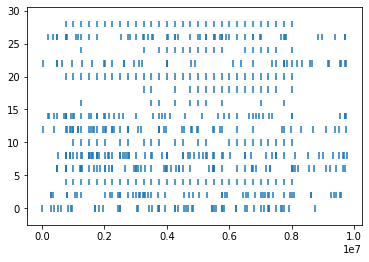

In [21]:
for i in range(len(data)):
    plt.eventplot(data[i].spike_time,lineoffsets= i*2)

In [8]:
n = neuron.Neuron('test')

In [24]:
spike_list = []
for i in range(len(data)):
    spike_list.append(data[i].spike_time)
    
# spike_list = [data[i].spike_time for i in range(len(data))]

In [32]:
n.spikes = n.load_spike_times(spike_list)
print(n.spikes.nbytes/(1024*1024), 'mb')

744.3991088867188 mb


## Now we smooth the array

In [89]:
b = gaussian_filter1d(n.spikes,10,1)


# Now that it is smoothed, lets wrap it

In [91]:
print("We have {} seconds".format(b.shape[1]/fs ))

We have 780.55904 seconds


## Cutting to a multiple of fs gives us:

In [92]:
cut_amount = int(b.shape[1]%fs)
cut_ind = b.shape[1] - cut_amount
print(cut_amount)

6988


In [93]:
b = b[:,:cut_ind]
print("We now have {} seconds".format(b.shape[1]/fs ))

We now have 780.0 seconds


In [96]:
stim_period = int(20*fs) #in seconds
b = b.reshape((b.shape[0],b.shape[1]//stim_period,stim_period))


In [99]:
print(b.shape)

(10, 39, 250000)


Fitting rank-1 models:   0%|          | 0/2 [00:00<?, ?it/s]

(10, 39, 250000)


/Users/seymour/miniconda3/envs/bgr/lib/python3.8/site-packages/tensortools/optimize/ncp_hals.py:185: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  Cp = factors[:, idx] @ grams[idx][:, p]
/Users/seymour/miniconda3/envs/bgr/lib/python3.8/site-packages/numba/core/typing/npydecl.py:933: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
                                                                    

Rank-1 models:  min obj, 0.93;  max obj, 0.93;  time to fit, 18.0s


Rank-2 models:  min obj, 0.92;  max obj, 0.92;  time to fit, 29.3s


Rank-3 models:  min obj, 0.90;  max obj, 0.90;  time to fit, 38.3s


Rank-4 models:  min obj, 0.89;  max obj, 0.89;  time to fit, 35.3s


Rank-5 models:  min obj, 0.88;  max obj, 0.88;  time to fit, 48.7s


Rank-6 models:  min obj, 0.87;  max obj, 0.88;  time to fit, 110.7s


Rank-7 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 118.0s


Rank-8 models:  min obj, 0.85;  max obj, 0.86;  time to fit, 87.7s


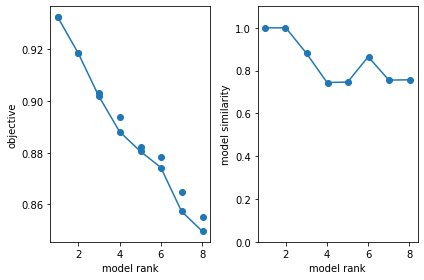

In [98]:
data = b# ... specify a numpy array holding the tensor you wish to fit
print(data.shape)

# Fit an ensemble of models, 4 random replicates / optimization runs per model rank
ensemble = tt.Ensemble(fit_method="ncp_hals")
ensemble.fit(data, ranks=range(1, 9), replicates=2)

fig, axes = plt.subplots(1, 2)
tt.plot_objective(ensemble, ax=axes[0])   # plot reconstruction error as a function of num components.
tt.plot_similarity(ensemble, ax=axes[1])  # plot model similarity as a function of num components.
fig.tight_layout()



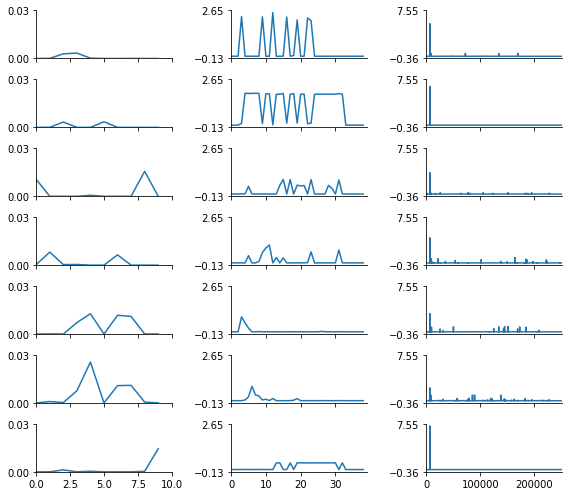

In [102]:
# Plot the low-d factors for an example model, e.g. rank-2, first optimization run / replicate.
num_components = 7
replicate = 0
tt.plot_factors(ensemble.factors(num_components)[replicate])  # plot the low-d factors

plt.show()

In [105]:
facts = ensemble.factors(5)[0].factors

In [107]:
nf = facts[0]
ef = facts[1]
tf = facts[2]

<IPython.core.display.Javascript object>


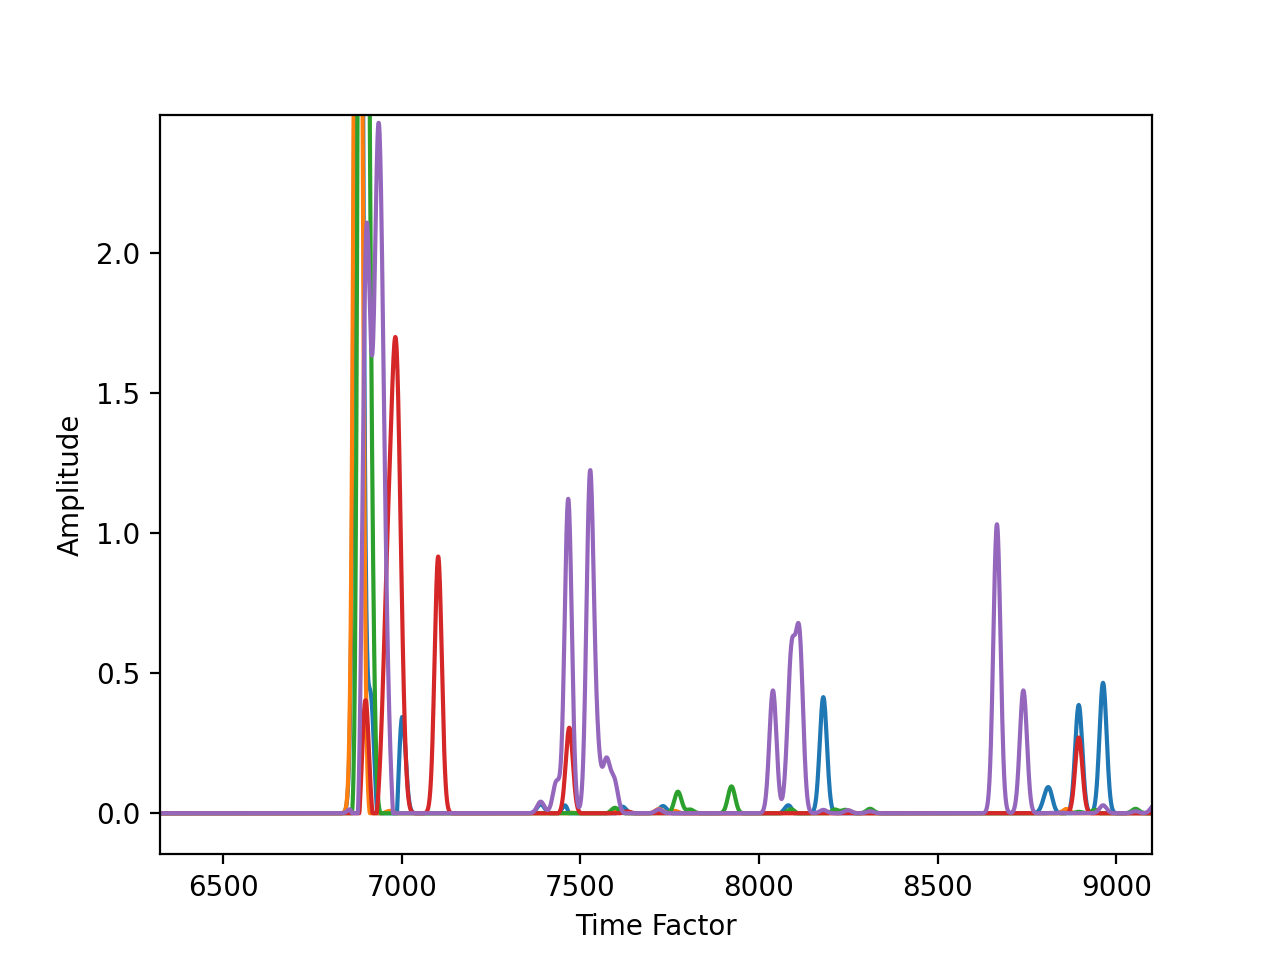

Text(0, 0.5, 'Amplitude')

In [111]:
%matplotlib notebook
plt.plot(tf)
plt.xlabel('Time Factor')
plt.ylabel('Amplitude')

# Now we do it withh all neurons in well A1


In [9]:
arrs = []
for pref in well_dict['A1'].values():
    
    #Load file
    nf = glob.glob(pref + '/spikeintf/outputs/neurons*')
    data = np.load(nf[0],allow_pickle=True)

    fs = data[0].fs
    
    
    #Make dense
    spike_list = [data[i].spike_time for i in range(len(data))]
    
    arrs.append(n.load_spike_times(spike_list))
    

In [10]:
def shorten_all_fs(nd,fs):
    min_time = min([i.shape[1] for i in nd])
    cut_amount = int(min_time%fs)
    cut_ind = min_time - cut_amount
    
    return np.vstack([i[:,:cut_ind] for i in nd])

def shorten_fs(nd,fs):
    cut_amount = int(nd.shape[1]%fs)
    cut_ind = nd.shape[1] - cut_amount
    
    return nd[:,:cut_ind]


In [11]:
c = shorten_all_fs(arrs,fs)
print(c.shape)
print("We now have {} seconds".format(c.shape[1]/fs ))

(147, 9737500)
We now have 779.0 seconds


## Reshape based on stim period

In [12]:
#Chop to be near multiple of stim period
stim_period = int(20*fs) #in seconds

c =shorten_fs(c,stim_period)
print(c.shape)

(147, 9500000)


In [13]:

c = c.reshape((c.shape[0],c.shape[1]//stim_period,stim_period))


Rank-1 models:  min obj, 0.99;  max obj, 0.99;  time to fit, 626.2s


Rank-2 models:  min obj, 0.99;  max obj, 0.99;  time to fit, 1714.9s


Rank-3 models:  min obj, 0.99;  max obj, 0.99;  time to fit, 2220.4s


Rank-4 models:  min obj, 0.99;  max obj, 0.99;  time to fit, 2458.9s


Rank-5 models:  min obj, 0.99;  max obj, 0.99;  time to fit, 2189.4s


Rank-6 models:  min obj, 0.99;  max obj, 0.99;  time to fit, 2123.2s


Rank-7 models:  min obj, 0.99;  max obj, 0.99;  time to fit, 2049.6s


Rank-8 models:  min obj, 0.99;  max obj, 0.99;  time to fit, 2819.9s


<IPython.core.display.Javascript object>


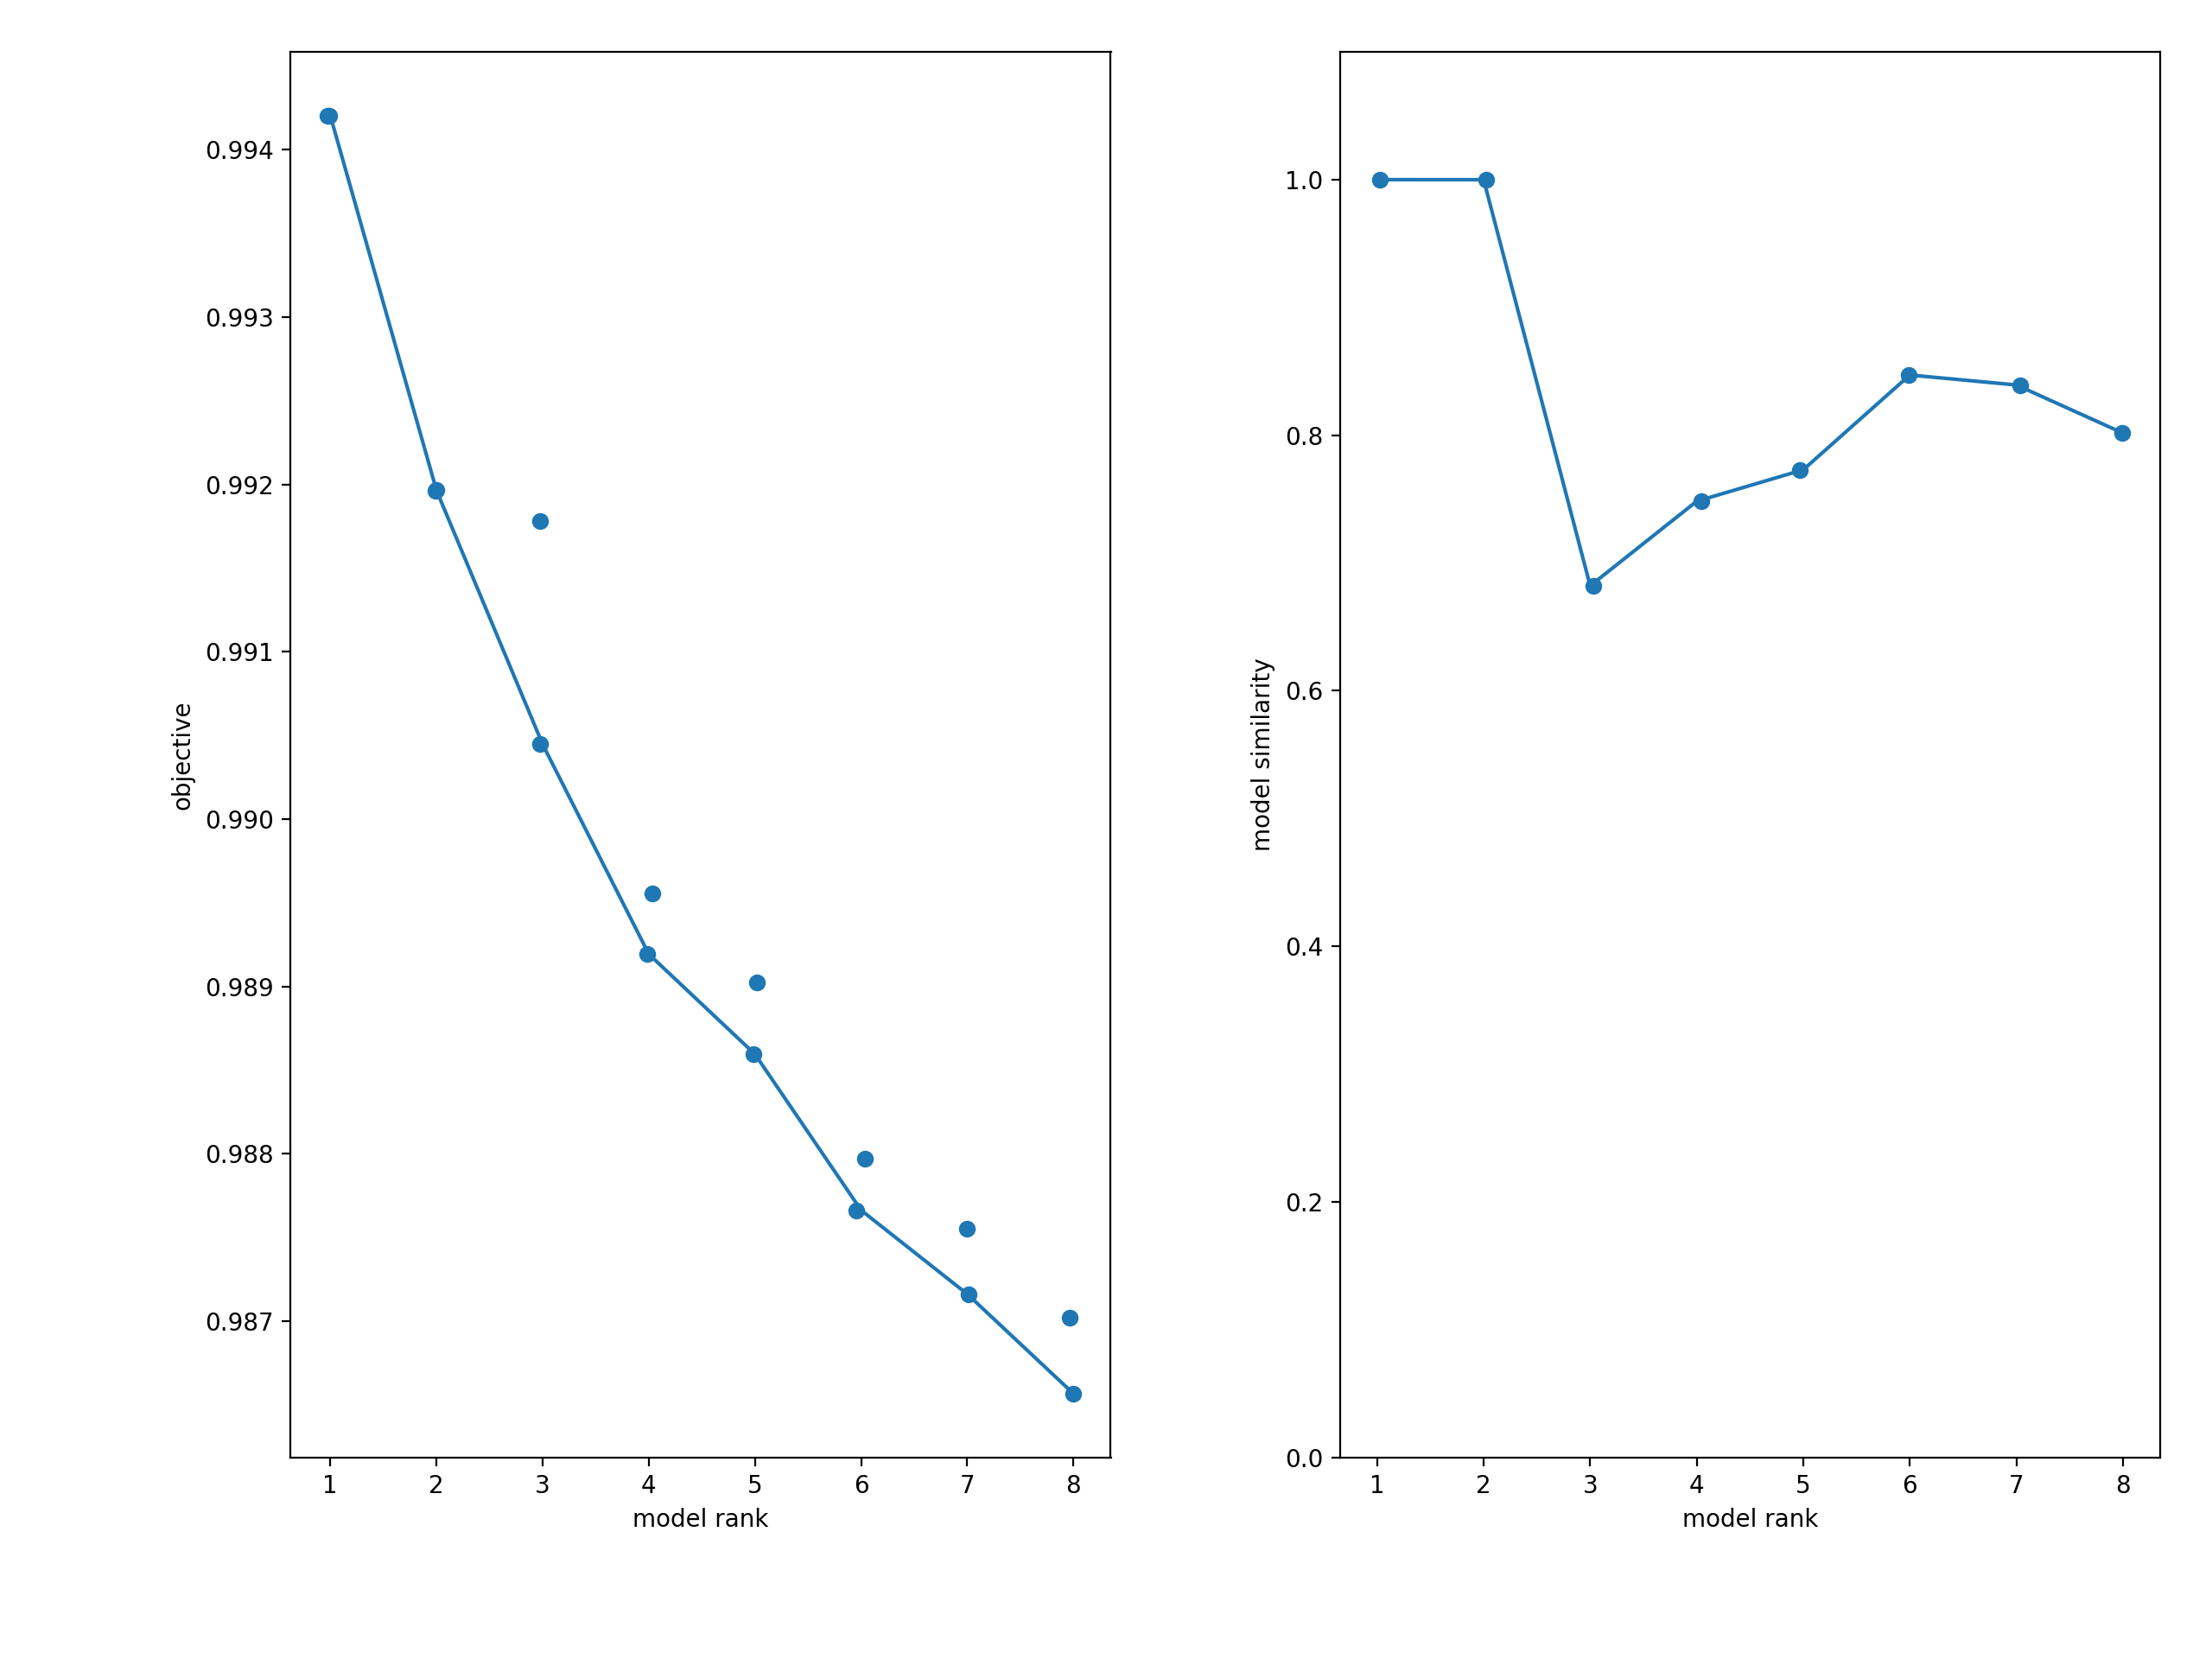

In [165]:


# Fit an ensemble of models, 4 random replicates / optimization runs per model rank
ensemble = tt.Ensemble(fit_method="ncp_hals")
ensemble.fit(c, ranks=range(1, 9), replicates=2)

fig, axes = plt.subplots(1, 2)
tt.plot_objective(ensemble, ax=axes[0])   # plot reconstruction error as a function of num components.
tt.plot_similarity(ensemble, ax=axes[1])  # plot model similarity as a function of num components.
fig.tight_layout()



In [166]:
%matplotlib inline

In [17]:
# Plot the low-d factors for an example model, e.g. rank-2, first optimization run / replicate.
num_components = 3
replicate = 0
tt.plot_factors(ensemble.factors(num_components)[replicate])  # plot the low-d factors

plt.show()

NameError: name 'ensemble' is not defined

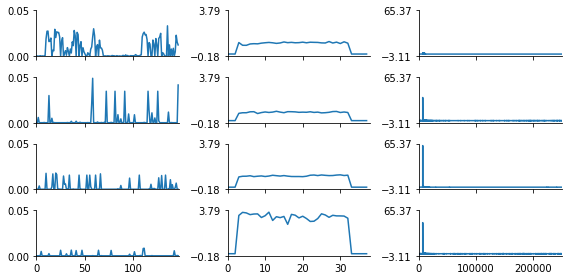

In [192]:
%matplotlib inline
# Plot the low-d factors for an example model, e.g. rank-2, first optimization run / replicate.
num_components = 4
replicate = 0
tt.plot_factors(ensemble.factors(num_components)[replicate])  # plot the low-d factors

plt.show()

In [176]:
facts = ensemble.factors(7)[0]
nf = facts[0]
ef = facts[1]
tf = facts[2]

(38, 7)


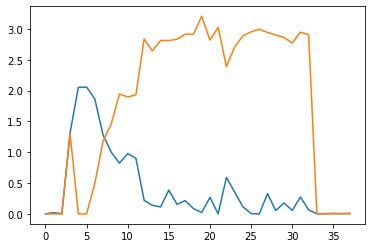

In [184]:

print(ef.shape)
plt.plot(ef[:,[0,1]])

In [82]:
%matplotlib notebook
print(tf.shape)
plt.plot(tf[:,[0,1]],alpha = .5)

NameError: name 'tf' is not defined

In [193]:
print(c.shape)

(147, 38, 250000)


In [76]:
z = c.mean(axis=1)[:10,:20000]

In [77]:
z.shape

(10, 20000)

<IPython.core.display.Javascript object>


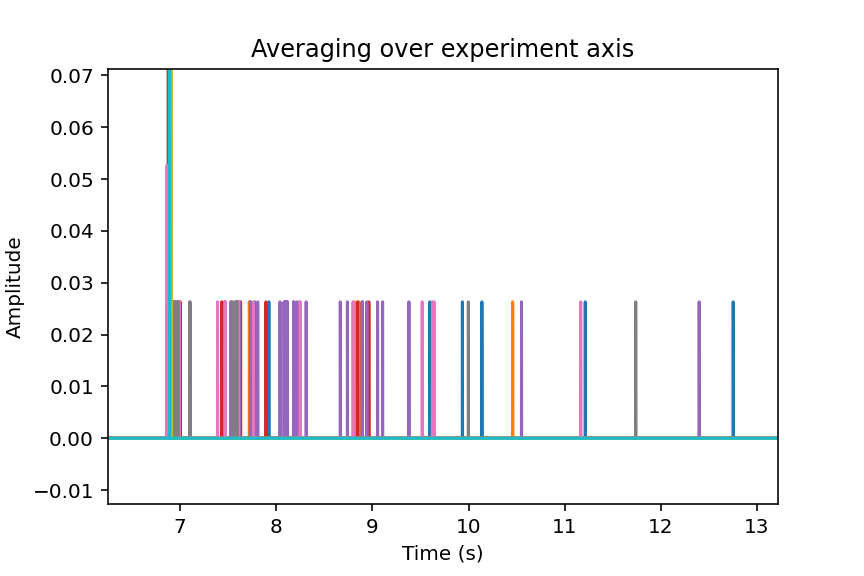

Text(0, 0.5, 'Amplitude')

In [81]:
%matplotlib notebook
plt.plot(np.arange(z.shape[1])/1000,z.T)
plt.title('Averaging over experiment axis')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

In [213]:
print(tf.shape)

(250000, 7)


In [214]:
plt.plot(np.arange(tf.shape[0]/100,tf)

SyntaxError: unexpected EOF while parsing (<ipython-input-214-06a459005a22>, line 1)

In [14]:
q = np.load('/Users/seymour/research/braingeneers/ephys/factors/500mV-20sec-A1-ens.npy',allow_pickle=True)

In [15]:
q = q.item()

(<Figure size 576x432 with 18 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object),
 array([[list([<matplotlib.lines.Line2D object at 0x74ac8b0d0>]),
         list([<matplotlib.lines.Line2D object at 0x74ac9bc10>]),
         list([<matplotlib.lines.Line2D object at 0x74aca2e50>])],
        [list([<matplotlib.lines.Line2D object at 0x74aca93d0>]),
         list([<matplotlib.lines.Line2D object at 0x74acb4160>]),
         list([<matplotlib.lines.Line2D object at 0x70f0c22e0>])],
        [list([<matplotlib.lines.Line2D object at 0x74acbd730>]),
         list([<matplotlib.lines.Line2D object at 0x74acc54c0>]),
         list([<matplotlib.lines.Line2D object at 0x74acc5dc0>])],
  

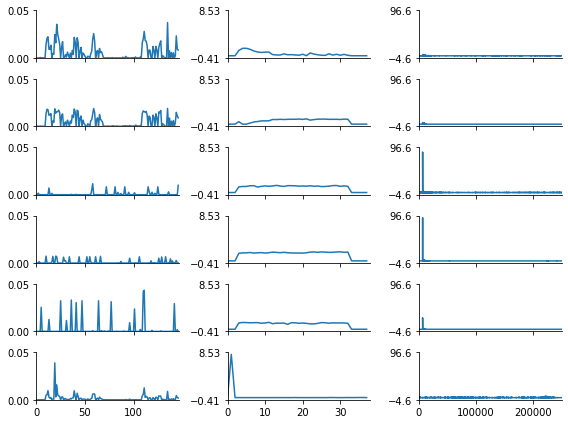

In [56]:
%matplotlib inline
tt.plot_factors(q.factors(6)[replicate])

In [18]:
num_components = 3
replicate = 0

In [19]:
facts = q.factors(num_components)[replicate]

<IPython.core.display.Javascript object>


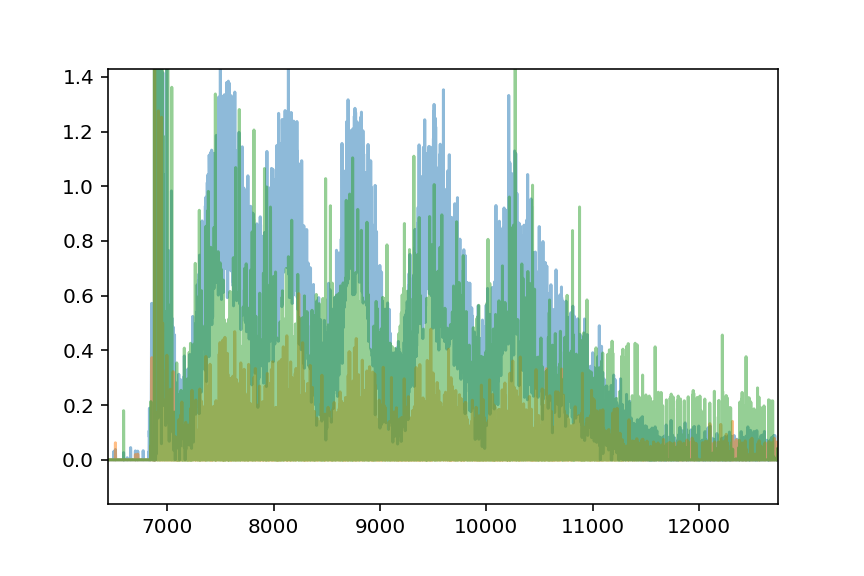

In [54]:
%matplotlib notebook
plt.plot(facts[2],alpha = .5)

In [20]:
q.similarities(7)

[1.0, 0.8393274026183076]

## Attempt to reduce it to 3 dims


In [21]:
num_components = 3
replicate = 0

f = q.factors(num_components)[replicate]
f.shape

(147, 38, 250000)

In [22]:
fact_num = 0

fact = f[fact_num]
print(fact.shape)

(147, 3)


In [23]:
print(c.shape)

(147, 38, 250000)


In [24]:
# for i in range(c.shape[1]):
#     for i in range(c.shape[2])
d = np.stack([np.matmul(b.T, fact).T for b in np.rollaxis(c,1,0)])

In [25]:
print(d.shape)

(38, 3, 250000)


# Plot 3d

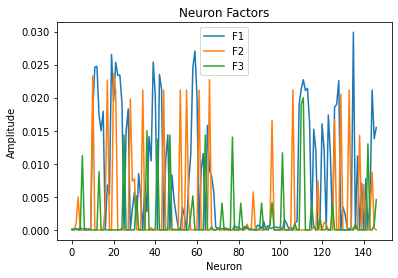

In [73]:
%matplotlib inline
fact = f[0]
plt.plot(fact)#,alpha=.5)
plt.title('Neuron Factors')
plt.xlabel('Neuron')
plt.ylabel('Amplitude')
plt.legend(['F1','F2','F3'])
# plt.axis([0,20000,0,2])

(0.0, 20000.0, 0.0, 1.0)

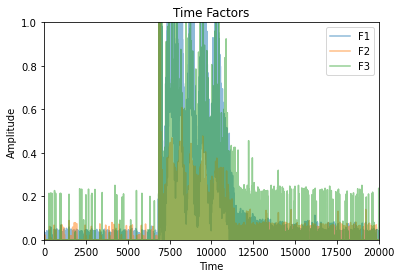

In [74]:
%matplotlib inline
fact = f[2]

plt.plot(fact,alpha=.5)
plt.title('Time Factors')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend(['F1','F2','F3'])
plt.axis([0,20000,0,1])

In [60]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

<IPython.core.display.Javascript object>


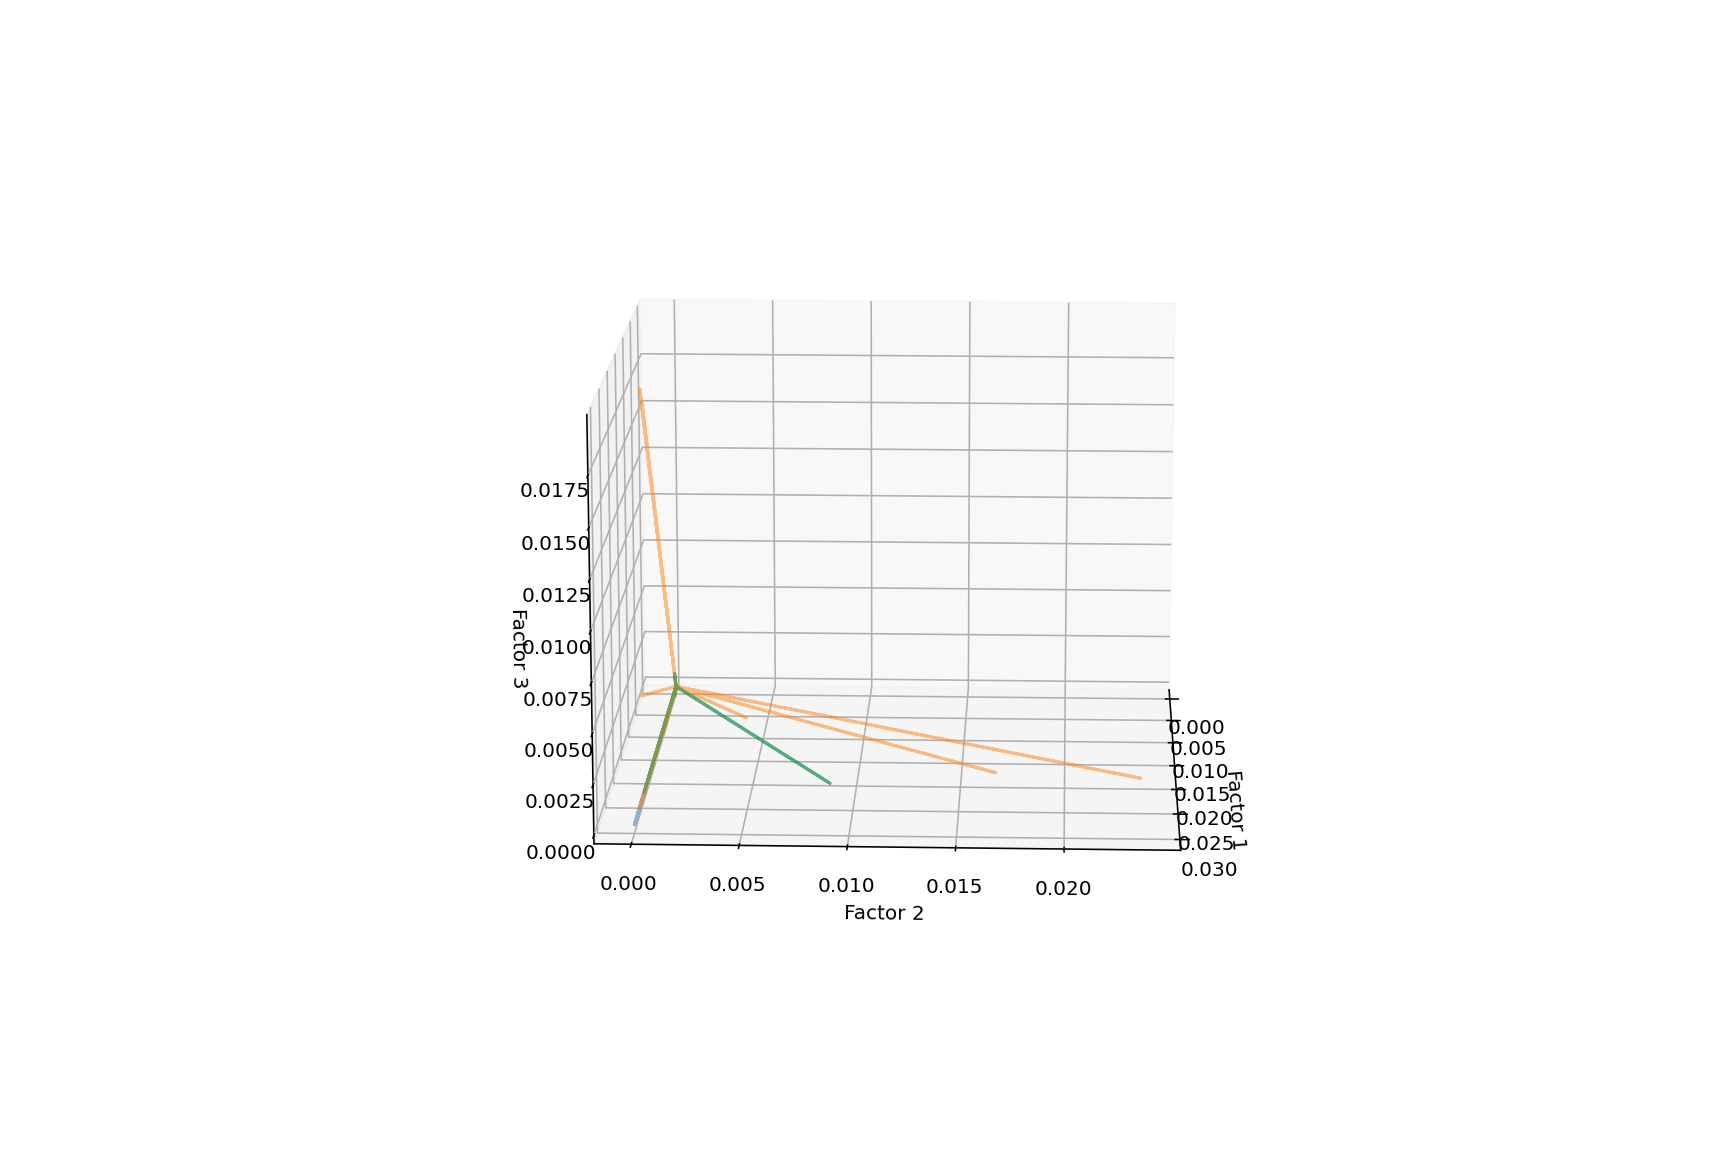

Text(0.5, 0, 'Factor 3')

In [80]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
st = 8000
en = 14000
for i in range(3):
    
    ax.plot(d[i,0,st:en], d[i,1,st:en],d[i,2,st:en],alpha=.5)

ax.set_xlabel('Factor 1')
ax.set_ylabel('Factor 2')
ax.set_zlabel('Factor 3')

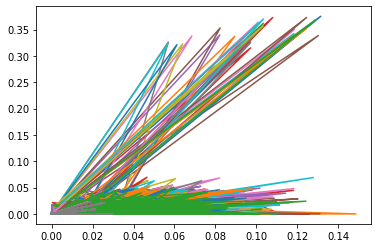

In [330]:
plt.plot(d[:,0,:plot_len].T, d[:,1,:plot_len].T)